# CAVITY Demo
### Examples of profiles for different Cavity<a name="cite_ref-1"></a>[<sup>1</sup>](#cite_note-1) galaxies.

In this tutorial I will show how to use the library *AstroPipe* for doing surface brightness **profiles** with the tools developed. We will:

1. Download the image from the Legacy Survey of the galaxy of interest
2. Mask all the sources that are not the galaxy
2. Compute the sky background level, standard deviation and the morphology of the galaxy.
3. Compute three different types of profiles
4. Use visualization tools to plot the image, mask and profile.


This is a work in progress, use at your own risk!

<span style="font-size:smaller;"><a name="cite_note-1"></a> [1.](#cite_ref-1) See [Cavity Website](https://cavity.caha.es/) for more info.</span>

### 1. Download the image from the Legacy Survey DR10

We will use the module *query* to download a cutout image from the galaxy NGC3344 in *r*-band from the Legacy Survey DR10. We will use this image to measure its surface brightness profiles. We first declare the right ascension and declination coordinates of the galaxy and the size of the cutout. Then, we call the function *des_mosaic* to download the image from the Legacy Survey DR10. First time we run this cell will take some minutes since it has to download the image, then when running again, it will check if its downloaded to avoid downloading it again.

In this example, it will take the different parameters from the catalog *cavity_demo.csv* file. You can change the **index** variable to change the galaxy.

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import os

from AstroPipe.query import des_mosaic
from os.path import join
from astropy.table import Table

# I ignore the warnings to make jupyter notebook's outputs prettier, 
# comment them for troubleshooting
import warnings
warnings.filterwarnings("ignore")
# %matplotlib widget

# Declare some varibales to help the process

index = 0                                 # index of the galaxy in the table
tbl = Table.read('cavity_demo.csv')
name =   tbl[index]['galaxy']             # name of the galaxy
ra,dec =  tbl[index][['RA','DEC']]        # ra and dec of galaxy
size =  0.15                              # size of the cutout in degress
outdir = 'temp/'                          # temporary directory to save files

# Set filename using the name of the galaxy and create the directory if it does not exist
filename = join(outdir,f'{name}_des.fits')
if not os.path.isdir(outdir): os.mkdir(outdir)

# Download the mosaic from DES if file does not exits
if not os.path.isfile(filename):
    des_mosaic(ra,dec,outdir=filename,width=size,bands='r',verbose=True)


/usr/local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print(name)

CAVITY52954


Once we have downloaded the image, we can create an Image class (*AstroPipe.classes.Image*) with the downloaded image. This class is an object that will help us work with astronomical images where there is a celestial object we want to study. It has some attributes and methods that can help us get information from the image and object. 

Once we define the class, given the hdu where its located and the zero point of the image, we can assign the coordinates of the object and use the built in method *show* to plot the surface brightness of the image.

pixel scale: 0.2630 and coordinates in pixels [x,y]: ([1026.05004728 1025.96301118])


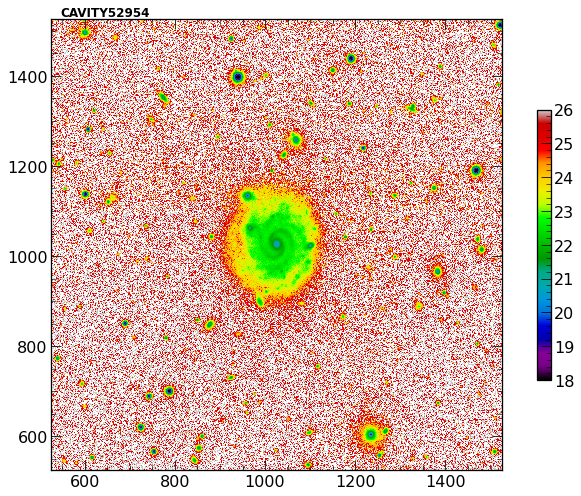

In [3]:
from AstroPipe.classes import Image 

image = Image(filename, hdu=0, zp=22.5)   # To work with magnitudes we need to set the zero-point of the image (zp)

image.obj(ra, dec)                        # Set the coordinates of object to study.
image.name = name                         # For Plot purposes   

# We can print the pixel scale, the pixel coordinates where the object is in the image, and visualize the image.
print(f'pixel scale: {image.pixel_scale:1.4f} and coordinates in pixels [x,y]: ({image.pix})')

ax = image.show(width=500, vmin=26, vmax=18, cmap='nipy_spectral')


### 2. Create a mask of the image.

Now we use the class *Directories* to stablish the directories where the data will be stored. Then, we call the routine *AstroPipe.masking.sexmask* that will produce an accurate mask of the image. This method is based on SExtractor, and it run it three different times with different configurations:
1. We smooth the image using the FABADA software and the $\sigma$ parameter estimated using sigma clipping of the background pixels.
1. Then, it runs SExtractor with a intermediate threshold to detect all the primary sources in the image.
2. Then, it runs SExtractor with a lower threshold and lower background to detect only the brightest sources in the image.
3. Finally, it runs SExtractor on the residual of the FABADA image minus a Gaussian smoothed version of the image. This last step aims to deblend point sources inside the region of the galaxy. It also has some filters to select regions to mask.

<AxesSubplot:>

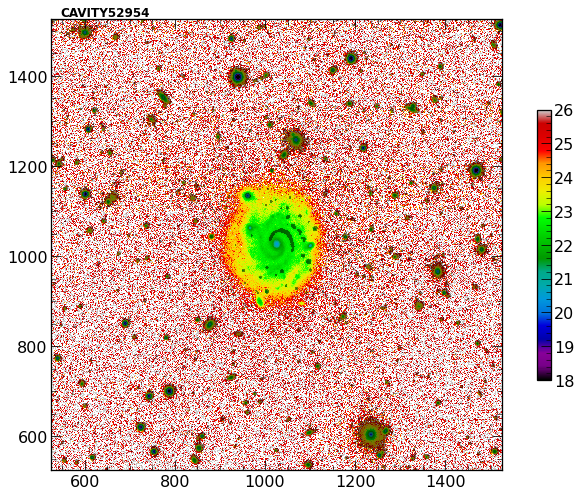

In [4]:
from AstroPipe.classes import Directories
from AstroPipe.masking import sexmask, fastmask
from astropy.io import fits

folders = Directories(name, path=os.path.dirname(filename))

if not os.path.isfile(folders.mask):
    # sexmask(image, folders)               # while SExtractor is not working
    mask = fastmask(image.data, (image.x,image.y), nsigma=1.0, fwhm=3)
    fits.PrimaryHDU(mask,image.header).writeto(folders.mask,overwrite=True)
    image.set_mask(mask)
else:
    image.set_mask(fits.getdata(folders.mask))

image.show(width=500, vmin=26, vmax=18, cmap='nipy_spectral')

### 3. Meassure the morphology of the galaxy and the sky background statistics.

Once we have the mask, we can use it to measure the morphology of the galaxy and the sky background statistics. We will use the method *get_morphology* of the *AstroPipe.classes.Image* object to do this. It will compute using a dilated binary mask of the non-masked pixels the positional angle, the ellipticity $1-b/a$ and an estimation of the radius of the galaxy (we store it in *reff* but it is not the effective radius of the galaxy). 

Then, we will use the method *get_background* of the object to measure the sky background level of the image. We do this by creating a profile of the galaxy using the morphological parameters until a plateau is found (sky region). We determine the plateau by the derivatives of this profiles (this can be improved, want to help?). Once the plateau is defined, we compute the sky value in two different ways:

1. By an elliptical aperture. We measure the sigma clipped median and standard deviation  ($\sigma$) of the non-masked pixel inside the aperture. Then, the sky values is defined as the median and the error as $\sigma/\sqrt{N}$ where $N$ is the number of non-masked pixels inside the aperture.
    
2. By random rectangular apertures. We create random rectangular apertures around the elliptical aperture. Then, we compute the median and standard deviation of the non-masked pixels inside of each aperture. The sky value is the median of all the medians of the boxes and the error is defined as the median of all $\sigma$ normalize by the $\sqrt{N}$, i.e., $<\vec{\sigma}>/\sqrt{N}$ where $N$ is the number of boxes.

Image morphology found:
PA = -85.21 deg ;  eps = 0.21
Background estimation:
Background = 7.26e-04 ;  Background std = 1.08e-04 ;  Background radius = 2.93e+02


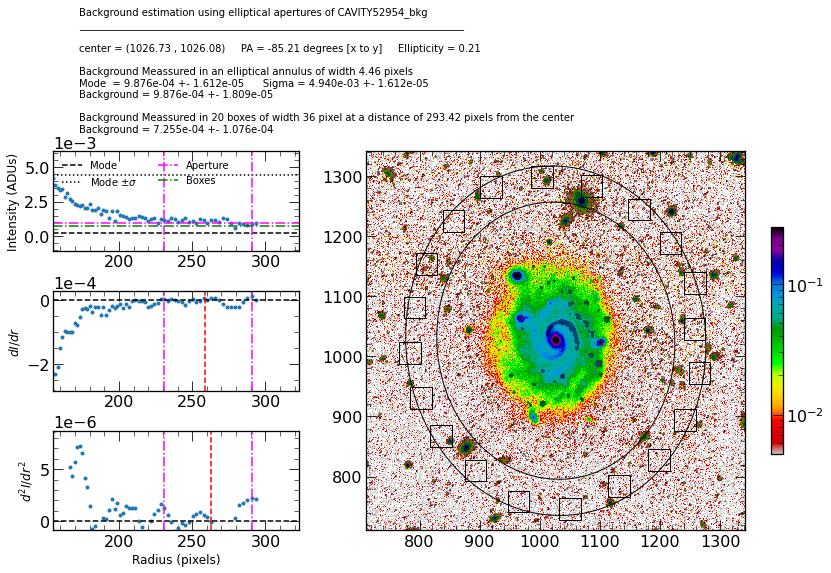

In [5]:

image.get_morphology()
image.get_background(growth_rate=1.05, out=join(folders.out,f'{name}_bkg.jpg'))

print('Image morphology found:')
print(f'PA = {image.pa:.2f} deg ;  eps = {image.eps:.2f}')
print('Background estimation:')
print(f'Background = {image.bkg:.2e} ;  Background std = {image.bkgstd:.2e} ;  Background radius = {image.bkgrad:.2e}')

### 4. Calculate the Surface Brightness Profiles fitting the isophotes of the galaxy.


We will use the **Elliptical Isophote Analysis** method implemented in *photutils.isophote* described by *Jedrzejewski (1987; MNRAS 226, 747)* to fit at each radial bin the morphological parameters for every ishophote. This method is quite old already, works just right, its quite slow and needs some parameters to start the procedure. In this sense we have to give the morphological parameters (pa, ellipticity and radius) for the initial step from which it will start the iterative fitting. This is very sensible and it can fail (see Troubleshooting 2)



**WARNING:** The method is very slow, and can take several minutes to complete the fitting process. Be patient :D. Also, be aware that warnings are disable and that the message of not being able to fit (see Troubleshooting 2) would not appear.


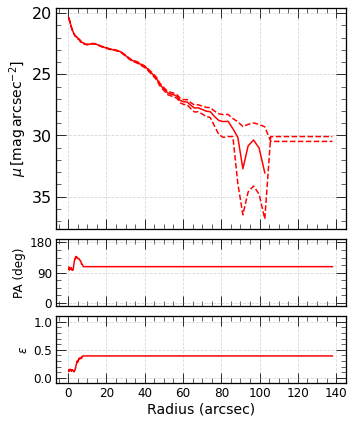

In [6]:
from AstroPipe.profile import Profile

# image.reff = image.reff/2 if index==1 else image.reff   # As mention before, to make it converge (see throubleshooting 2.)

image.reff = 10
if not os.path.isfile(folders.profile):
    profile = image.isophotal_photometry(max_r=1.8*image.bkgrad)
    profile.write(folders.profile)
else:
    profile = Profile(filename=folders.profile)
    profile.brightness()

fig = profile.plot()

Now, we can construct an elliptical profile with fixed parameters using the *radial_photometry* method in the **Image class**. 

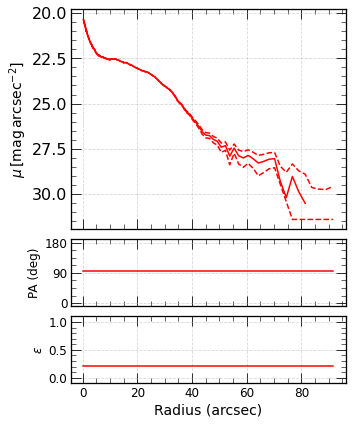

In [7]:
fix_profile = image.radial_photometry(max_r=1.2*image.bkgrad)
figure = fix_profile.plot()


### 5. Use some of the functions to get pretty figures.

Having the *AstroPipe.classes.Image* and *Profile* classes defined we can make use of built-in functions to produce pretty images. 

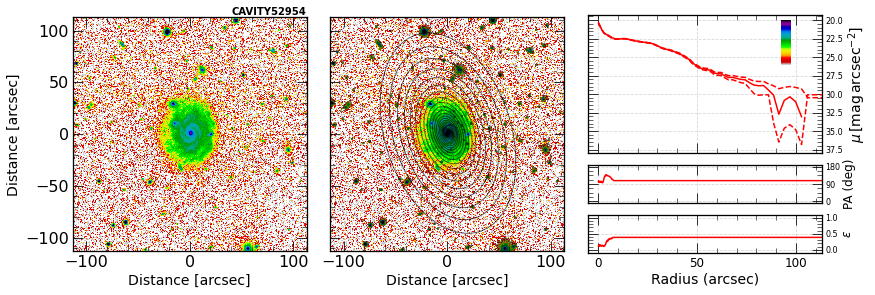

In [8]:
from AstroPipe.plotting import surface_figure

fig = surface_figure(image, profile, vmin=20, vmax=26, out=join(folders.out,f'{name}_photometry.jpg'))


### Troubleshooting

Alright, hopefully we were able to go through all the steps of the jupyter notebook. In the best scenario, everything worked perfect, and you are more than satisfied with the results. However, this is usually far from reality ;D. In this section I will try to explain some methods that I developed to work with different changes.

1. **Mask editing**

Since the mask has a method to try to mask inner regions of the galaxy, sometimes is not very efficient and gets quite some regions inside the galaxy masked that should no be masked. I am developing a interactive tool, based on *matplotlib* to be able to edit the mask. This interact

**WARNING:** This tool is meant to be ran from a terminal, not from a jupyter notebook. I have been able to use it within the jupyter notebook, but it may not worked perfect. Also, by the date this jupyter is uploaded, the tool is not definitive yet so it may not run perfect. Furthermore, I have not optimized and may not work smoothly. I am working on this to make it better.  

In [9]:
#%matplotlib qt    ## Uncomment this line to make the plot interactive
from AstroPipe.plotting import interactive_mask_modify
 
# interactive_mask_modify(image,vmin=20, vmax=26)     ## Uncomment this line to give it a try

2. **NO MEANINGFULL FIT:** Warning message of *Photutils.ellipse*. Change manualy the morphological parameters.

You will recognize when you get an annoying warning of NO MEANINGFULL FIT. In this case, you have to change the initial parameters, usually changing the *reff* of the *image* class attribute to something lower works. In this way you try to fit in the first step a region with very high SNR. Then, the algorithm will be able to start the iterative process and will be able to fit the isophotes.

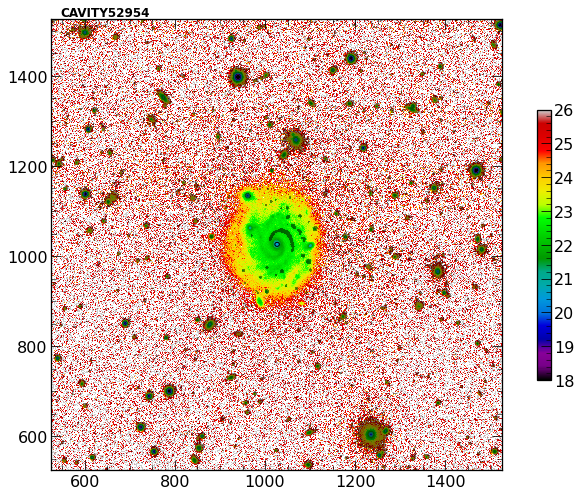

In [10]:
import matplotlib.patches as patches

# Changing the morphological parameters on the image class

image.pa = 0            # Positional Angle respect x axis
image.eps = 0.1         # Ellipticity (1-b/a)
image.reff = 5          # Some estimation of the effective radius


# Plotting an ellipse to visualize the morphology
ax = image.show(width=500, vmin=26, vmax=18, cmap='nipy_spectral')
ellipse_patch = patches.Ellipse(image.pix, 2*image.reff,
                2*image.reff*(1-image.eps), image.pa,
                color='k', fill=False)

ax.add_patch(ellipse_patch)


2. **Sky background**

Let's say that in the plot above we are not convince about the sky background level. In this sense, with the previous statistics we can change the value of the sky, and compute the surface brightness again and plot the result in a very simple way. In my experience, it also gives you more information the standard deviation of the sky value, than the sky value itself, even more if the image comes from surveys that already have the sky removed. 

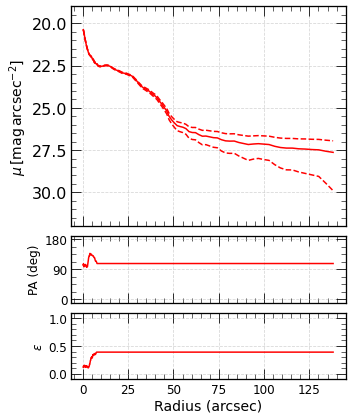

In [11]:
# 2. Sky background

profile.bkg = -1.6e-4         # We set manually the sky background
profile.bkgstd = 5e-4       # We set manually the sky background std
profile.brightness()        # We transform the counts to surface brightness
fig = profile.plot()        # and plot the result.
fig.axes[1].set_ylim([32,19])

profile.bkg = image.bkg
profile.bkgstd = image.bkgstd   
profile.brightness()


3. **Modify Profile Parameters and Extension**

Imagine we want to change the morphological parameters in some range of the profile, or we want to extend the profile to a larger radius. 

In [14]:
# Work in progress
